## Introduction

> This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

> Our analysis will try to answer questions of how duration between booking and reservation and other factors affect reservation price. Further questions of price analysis will also be performed to find optimum independent parameters to find minimum dependent variable value, in this case, the booking price.

## Import Libraries
The following commands must be run to install required libraries:
> - *pip install geopy*
> - *pip install shaply*
> - *pip install matplotlib*
> - *pip install plotly*
> - *pip install cufflinks*

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
import seaborn as sns

## Exploratory Analysis

In [2]:
df_hotel =pd.read_csv("hotel_bookings.csv", skiprows=0, header=0)
df_hotel.columns
df_hotel.shape
#df_hotel.info()

(119390, 32)

In [3]:
weekday = []
isWeekend = []
for index, row in df_hotel.iterrows():
    year = df_hotel['arrival_date_year'].iloc[index]
    month_name = df_hotel['arrival_date_month'].iloc[index]
    month_number = datetime.datetime.strptime(month_name, '%B').month
    dayOfMonth = df_hotel['arrival_date_day_of_month'].iloc[index]
    dayOfWeek = datetime.datetime(year,month_number,dayOfMonth).weekday()
    weekday.append(dayOfWeek)
    if (dayOfWeek>4):
        isWeekend.append(1)
    else:
        isWeekend.append(0)
        
df_hotel['arrival_weekday_num'] = weekday
df_hotel['arrival_day_is_weekend'] = isWeekend

df_hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_weekday_num,arrival_day_is_weekend
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0


In [4]:
print(df_hotel.isna().sum()) # check for null values

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
df_hotel['company'].nunique()
df_hotel['agent'].unique()
#df_hotel['agent'].value_counts()
# try with/without company hot-encoded

array([ nan, 304., 240., 303.,  15., 241.,   8., 250., 115.,   5., 175.,
       134., 156., 243., 242.,   3., 105.,  40., 147., 306., 184.,  96.,
         2., 127.,  95., 146.,   9., 177.,   6., 143., 244., 149., 167.,
       300., 171., 305.,  67., 196., 152., 142., 261., 104.,  36.,  26.,
        29., 258., 110.,  71., 181.,  88., 251., 275.,  69., 248., 208.,
       256., 314., 126., 281., 273., 253., 185., 330., 334., 328., 326.,
       321., 324., 313.,  38., 155.,  68., 335., 308., 332.,  94., 348.,
       310., 339., 375.,  66., 327., 387., 298.,  91., 245., 385., 257.,
       393., 168., 405., 249., 315.,  75., 128., 307.,  11., 436.,   1.,
       201., 183., 223., 368., 336., 291., 464., 411., 481.,  10., 154.,
       468., 410., 390., 440., 495., 492., 493., 434.,  57., 531., 420.,
       483., 526., 472., 429.,  16., 446.,  34.,  78., 139., 252., 270.,
        47., 114., 301., 193., 182., 135., 350., 195., 352., 355., 159.,
       363., 384., 360., 331., 367.,  64., 406., 16

In [6]:
#scrub the data (has Nan to children,company,agent,country)
# We should convert agent to binary column, indicating whether agent was used or not
# company can be dropped.


#-- Company (column) values are very much spread out without patterns. so can drop this column?
#-- agent (column) values are very much spread out without patterns. so can drop this column?
#-- drop agent,company
# fill median values to missing children
# drop rows with Nan values for country


#df_hotel=df_hotel.drop(['agent','company'],axis=1) # vijaya -commented out -27mar - Action item1
df_hotel['agent'].fillna(0, inplace=True)  # fill nan values with 0 -- VIjaya -mar27 - Action item 1
df_hotel.loc[df_hotel['agent'] >0, 'agent'] = 1 # Filll all non nan values with 1
df_hotel['agent'].value_counts()
df_hotel['company'].fillna(0, inplace=True)  # fill nan values with 0 -- VIjaya -mar27 - Action item 1
df_hotel.loc[df_hotel['company'] >0, 'company'] = 1 # Filll all non nan values with 1
df_hotel['company'].value_counts()

df_hotel['children'].fillna(df_hotel['children'].median(),inplace=True)
df_hotel=df_hotel.dropna(subset=["country"]) 
df_hotel.isna().sum()

df_hotel.shape


(118902, 34)

In [7]:

#filter only data of countries , which has atleast 100 recods   -- Action item 3
df_hotel = df_hotel.groupby('country').filter(lambda x: len(x) >= 100)

print(df_hotel.shape)

df_hotel['country'].value_counts()
df_hotel['country'].nunique()


(116512, 34)


38

In [8]:

# Instead of doing this, we should:
# One hot encode arrival_date_month
# Leave arrival_date_day_of_month as is
# arrival_date_week_number should be dropped.
# derive week day from year, month and day of month
# derive weekend day or not from above

month={'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12', }

df_hotel['mth']=df_hotel['arrival_date_month'].map(month)
df_hotel['date'] = df_hotel.arrival_date_day_of_month.map("{:02}".format)
df_hotel['mdt_arrival']=df_hotel['mth']+df_hotel['date'] 
df_hotel=df_hotel.drop(['mth','date'],axis=1)
print(df_hotel.shape)
#df_hotel.info()
df_hotel.head(5)



(116512, 35)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_weekday_num,arrival_day_is_weekend,mdt_arrival
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0,0701
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0,0701
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0,0701
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0,0701
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0,0701


In [9]:
df_hotel['arrival_date_month'].unique()  #vijaya - Mar27 - Action Item 9

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [10]:
df_hotel['meal'].unique()
#df_hotel['is_canceled'].value_counts()
#df_hotel['booking_changes'].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [11]:
df_hotel['deposit_type'].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [12]:
df_hotel['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [13]:
df_hotel['distribution_channel'].unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [14]:
df_hotel['assigned_room_type'].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'L', 'K', 'P'],
      dtype=object)

In [15]:
df_hotel['country'].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'ARG',
       'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD', 'DNK',
       'RUS', 'SWE', 'AUS', 'CZE', 'BRA', 'FIN', 'LUX', 'IND', 'CHN',
       'MAR', 'SRB', 'AUT', 'TUR', 'AGO', 'ISR', 'DZA', 'KOR', 'HUN',
       'HRV', 'JPN'], dtype=object)

In [16]:
#Drop unwanted columns

# Should not drop: is_cancelled, arrival_date_month(one hot encode instead), arrival_date_day_of_month, is_repeated_guest,
#               previous_cancellations, previous_bookings_not_canceled, booking_changes, 
# should drop: arrival_date_week_number, reservation_status_date
# should encode: meal, deposit_type, days_in_waiting_list, total_of_special_requests, reservation_status, distribution_channel, assigned_room_type

#removed 'is_cancelled',,'arrival_date_day_of_month','is_repeated_guest',
#'previous_cancellations' ,'previous_bookings_not_canceled','booking_changes','days_in_waiting_list','total_of_special_requests'
#from drop list -- march 27-- Vijaya
#'arrival_date_month','meal', 'deposit_type', 'reservation_status', - hot encode- VC
#'distribution_channel', 'assigned_room_type', 'country' - hotencode-VC

df_hotel=df_hotel.drop(['arrival_date_year','arrival_date_week_number','reservation_status_date'],axis=1)

In [17]:
#Convert datatypes
df_hotel['mdt_arrival']=df_hotel['mdt_arrival'].map(lambda x: int(x)) # conver string to Int values

In [18]:
#df_hotel.isna().sum()
df_hotel.shape

(116512, 32)

In [19]:
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116512 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             116512 non-null object
is_canceled                       116512 non-null int64
lead_time                         116512 non-null int64
arrival_date_month                116512 non-null object
arrival_date_day_of_month         116512 non-null int64
stays_in_weekend_nights           116512 non-null int64
stays_in_week_nights              116512 non-null int64
adults                            116512 non-null int64
children                          116512 non-null float64
babies                            116512 non-null int64
meal                              116512 non-null object
country                           116512 non-null object
market_segment                    116512 non-null object
distribution_channel              116512 non-null object
is_repeated_guest                 116512 non-null int64
previous_cancellations            116512 

total columns: (116512, 32)
total categorical columns :(116512, 102)
total features after Scrub: (119331, 123)


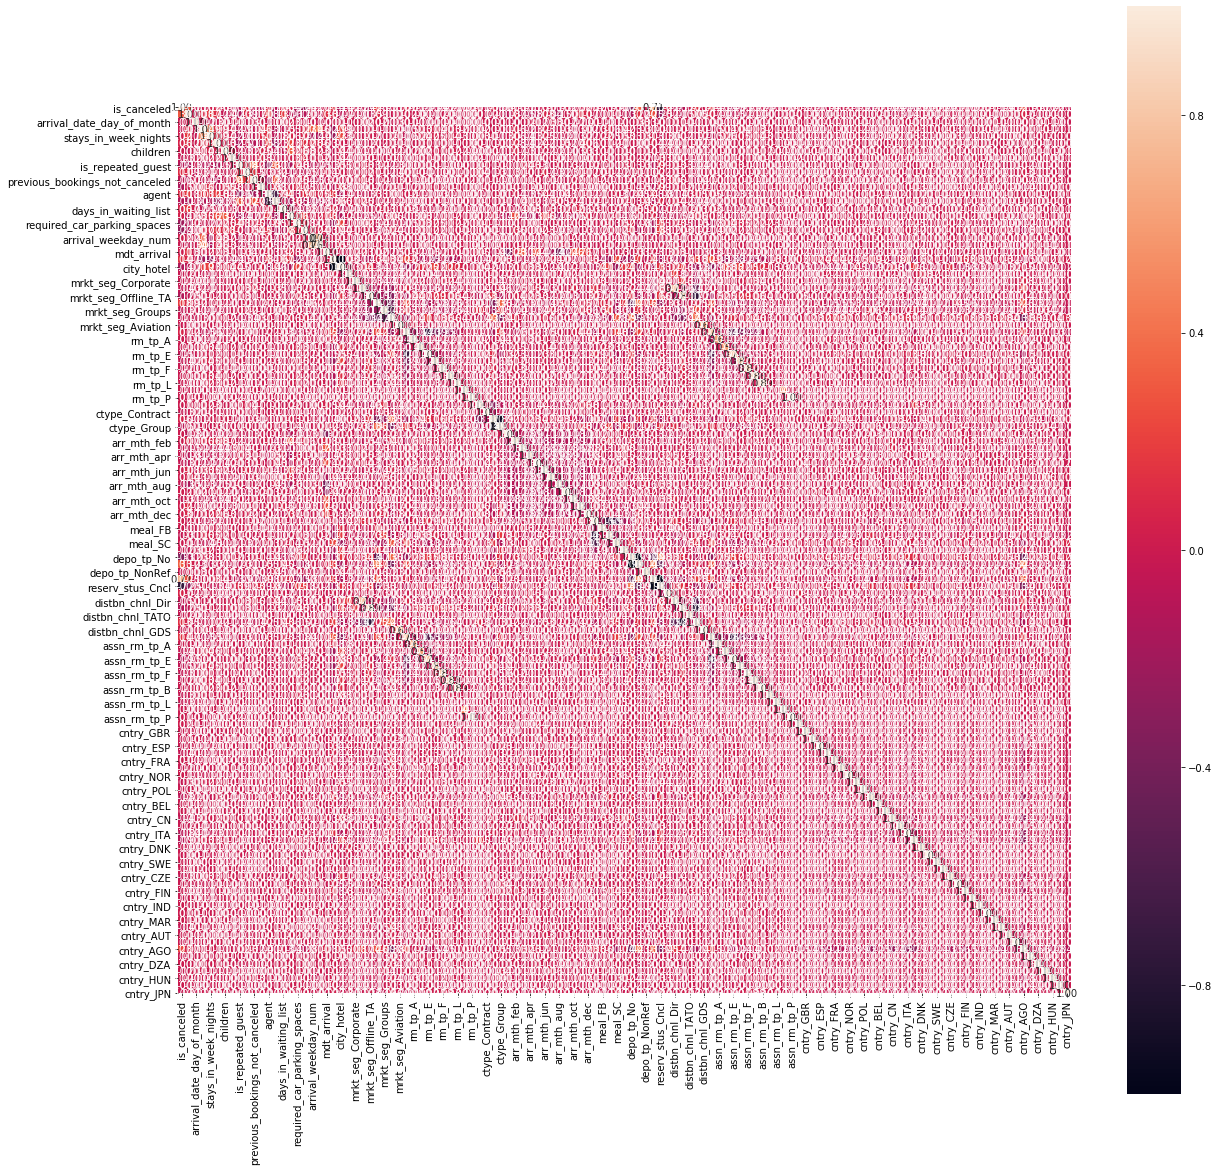

In [20]:
#df_hotel.hotel.unique()

#Build a pipeline for normalizer,OneHotEncoder

df_hotel_numeric=["lead_time","stays_in_weekend_nights",'stays_in_week_nights','adults','children','babies','adr','required_car_parking_spaces','mdt_arrival'] 
print("total columns: "+str(df_hotel.shape))
#print("total Numeric columns: "+str(df_hotel_numeric.shape))
num_pipeline = Pipeline([
        ('normalizer', MinMaxScaler())
    ])
num_attribs = list(df_hotel_numeric) # list all the numeric features
cat_attribs = ["hotel","market_segment","reserved_room_type","customer_type","arrival_date_month","meal","deposit_type",
              "reservation_status","distribution_channel","assigned_room_type","country"] # added "arrival_date_month"-VC-Action#9
full_pipeline = ColumnTransformer([
       # ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

      
hotel_prepared = full_pipeline.fit_transform(df_hotel)
print("total categorical columns :"+str(hotel_prepared.shape))
#print(type(hotel_prepared))




#print(df_hotel_prepared.head())
cols=['Resort_hotel','city_hotel',
      'mrkt_seg_Direct','mrkt_seg_Corporate','mrkt_seg_Online_TA','mrkt_seg_Offline_TA',
      'mrkt_seg_Compmtry', 'mrkt_seg_Groups', 'mrkt_seg_Undefined', 'mrkt_seg_Aviation',
      'rm_tp_C', 'rm_tp_A','rm_tp_D','rm_tp_E','rm_tp_G','rm_tp_F','rm_tp_H',
      'rm_tp_L','rm_tp_B','rm_tp_P',
      'ctype_Transient', 'ctype_Contract','ctype_Transient-Party', 'ctype_Group',
      'arr_mth_jan','arr_mth_feb','arr_mth_mar','arr_mth_apr','arr_mth_may','arr_mth_jun',
      'arr_mth_jly','arr_mth_aug','arr_mth_sep','arr_mth_oct','arr_mth_nov','arr_mth_dec',
      'meal_BB','meal_FB','meal_HB','meal_SC','meal_Undef',
      'depo_tp_No','depo_tp_Ref','depo_tp_NonRef',
      'reserv_stus_Ckout','reserv_stus_Cncl','reserv_stus_Noshow',
      'distbn_chnl_Dir','distbn_chnl_Corp','distbn_chnl_TATO','distbn_chnl_Undef','distbn_chnl_GDS',
      'assn_rm_tp_C','assn_rm_tp_A','assn_rm_tp_D','assn_rm_tp_E','assn_rm_tp_G','assn_rm_tp_F','assn_rm_tp_I',
      'assn_rm_tp_B','assn_rm_tp_H','assn_rm_tp_L','assn_rm_tp_K','assn_rm_tp_P',
      'cntry_PRT', 'cntry_GBR', 'cntry_USA', 'cntry_ESP', 'cntry_IRL', 'cntry_FRA', 'cntry_ROU', 'cntry_NOR',
      'cntry_ARG','cntry_POL', 'cntry_DEU', 'cntry_BEL', 'cntry_CHE', 'cntry_CN', 'cntry_GRC', 'cntry_ITA', 
      'cntry_NLD', 'cntry_DNK','cntry_RUS', 'cntry_SWE', 'cntry_AUS', 'cntry_CZE', 'cntry_BRA', 'cntry_FIN',
      'cntry_LUX', 'cntry_IND', 'cntry_CHN','cntry_MAR', 'cntry_SRB', 'cntry_AUT', 'cntry_TUR', 'cntry_AGO',
      'cntry_ISR', 'cntry_DZA', 'cntry_KOR', 'cntry_HUN','cntry_HRV', 'cntry_JPN'] #Action#9- VC

df_hotel_prepared=pd.DataFrame(hotel_prepared.toarray(),columns=cols)

df_hotel=df_hotel.drop(['hotel','market_segment','reserved_room_type','customer_type',"arrival_date_month","meal"
                       ,"deposit_type","reservation_status","distribution_channel","assigned_room_type","country"],axis=1)
df_hotel_feature=pd.concat([df_hotel,df_hotel_prepared],axis=1)
print("total features after Scrub: "+str(df_hotel_feature.shape))
plt.figure(figsize=(20,20))
sns.heatmap(df_hotel_feature.corr(),cbar=True, annot=True, square=True, fmt='.2f')
plt.show()




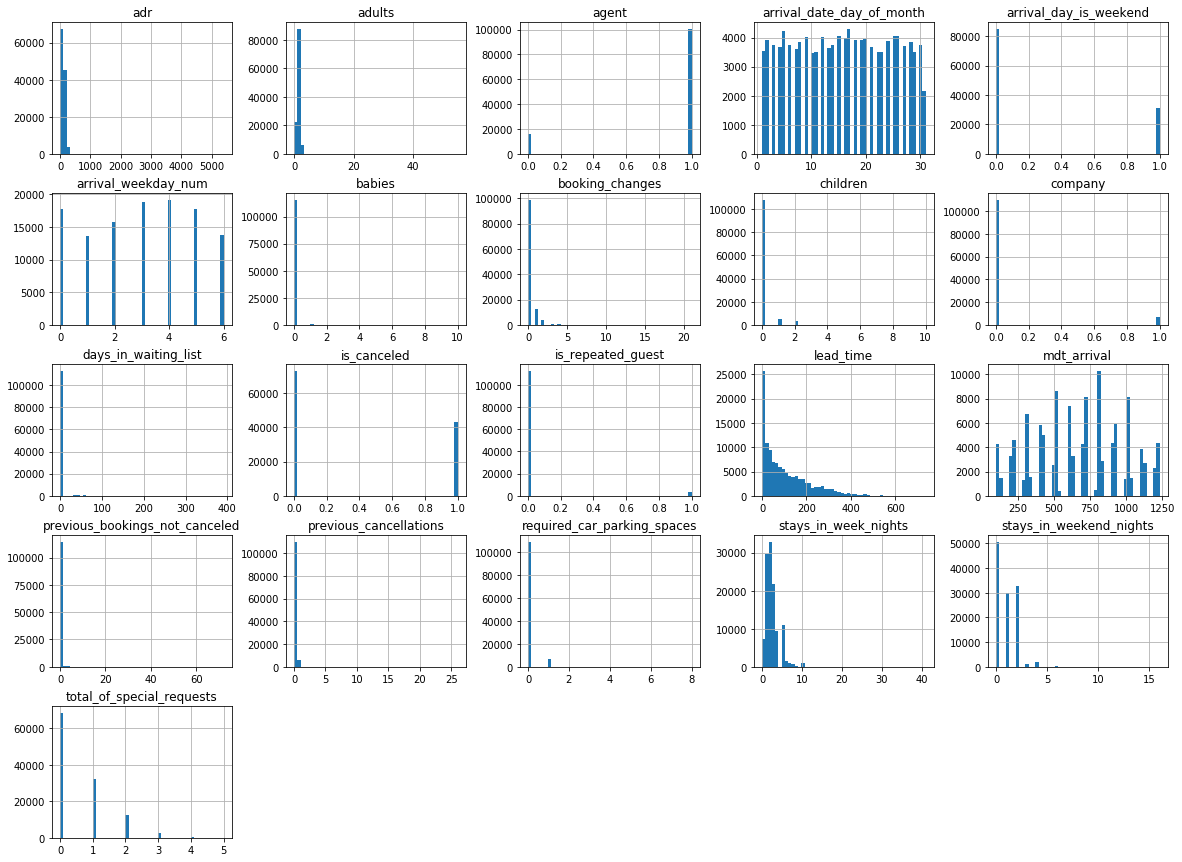

In [21]:
df_hotel.hist(bins=50, figsize=(20,15));

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = df_hotel_prepared
X.head()
#train_set, test_set = train_test_split(df_hotel, 0.2)
#print(len(train_set), "train +", len(test_set), "test")

,Resort_hotel,city_hotel,mrkt_seg_Direct,mrkt_seg_Corporate,mrkt_seg_Online_TA,mrkt_seg_Offline_TA,mrkt_seg_Compmtry,mrkt_seg_Groups,mrkt_seg_Undefined,mrkt_seg_Aviation,...,cntry_SRB,cntry_AUT,cntry_TUR,cntry_AGO,cntry_ISR,cntry_DZA,cntry_KOR,cntry_HUN,cntry_HRV,cntry_JPN
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
